This notebook contains combination combination of our work on the LTN. It consinsts of the most important findings and LTN implementation in a structured way. This is not all the code that was developed during the project and only the most interesting parts. More code is available on the development branch in few separate notebooks. 

# Import of libraries and data preparation

In [28]:
import torch
import pandas as pd
import ltn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


## Loading the dataset

In [ ]:
# OC: Windows
ds_l = pd.read_csv('src\data\Stud_E-mobility_data_staticLimit.csv')

In [3]:
# OC: MacOS
ds_l = pd.read_csv('src/data/Stud_E-mobility_data_staticLimit.csv')

Main dataset with no labeling

In [4]:
ds_l.columns

Index(['_time', 'GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT',
       'DEMAND_LIMIT_INDICATOR', 'BATTERY_SOC', 'BATTERY_DISCHARGE_POWER',
       'BATTERY_CHARGED_ENERGY', 'BATTERY_DISCHARGED_ENERGY', 'PV_POWER',
       'PV_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER',
       'WALLBOX_1_ENERGY', 'WALLBOX_1_POWER', 'WALLBOX_2_ENERGY',
       'WALLBOX_2_POWER', 'WALLBOX_3_ENERGY', 'WALLBOX_3_POWER',
       'WALLBOX_A_ENERGY', 'WALLBOX_A_POWER', 'WALLBOX_B_ENERGY',
       'WALLBOX_B_POWER', 'WALLBOX_C_ENERGY', 'WALLBOX_C_POWER',
       'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_FASTCHARGER_POWER'],
      dtype='object')

In [5]:
ds = ds_l[['GARAGE_EXTERNAL_POWER','DEMAND_LIMIT',
       'BATTERY_SOC', 'BATTERY_DISCHARGE_POWER',
       'WALLBOX_FASTCHARGER_POWER', 'PV_POWER'
    ]]

Dataset that is independent form GT


Ground truth labeling (whole dataset)

In [7]:
gt_ds = ds.copy()

In [8]:
def label_charging(row):
    if row["BATTERY_SOC"] > 80:
        return "Fully Covered by Local Battery"
    elif 40 <= row["BATTERY_SOC"] < 80:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif 15 <= row["BATTERY_SOC"] <= 40:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    # elif row["BATTERY_SOC"] < 15:
    elif row["BATTERY_SOC"] < 15:
        return "Battery Discharge Stopped due to Battery Health"
    else:
        print(row["BATTERY_SOC"])
        print(row["GARAGE_EXTERNAL_POWER"])
        return "Unknown"

# Apply the labeling function to create the new column "DRAWN_FROM"
gt_ds["DRAWN_FROM"] = gt_ds.apply(label_charging, axis=1)

In [9]:
gt_ds['DRAWN_FROM'].value_counts()

DRAWN_FROM
Battery Charged from Grid                          54783
Partially Covered by Local Battery                  4457
Battery Discharge Stopped due to Battery Health      202
Name: count, dtype: int64

Small labeled dataset (only the part that follows GT)

In [10]:
delta = 0.5 # Tolerance for the power limit
SOC_less_15 = gt_ds[(gt_ds["BATTERY_SOC"]<=15) & (gt_ds["BATTERY_DISCHARGE_POWER"]<=0)]
SOC_less_40_1 = gt_ds[(gt_ds["BATTERY_SOC"]>15) &(gt_ds["BATTERY_SOC"]<40) & (gt_ds["GARAGE_EXTERNAL_POWER"]<50) & (gt_ds["BATTERY_DISCHARGE_POWER"]<0)]
SOC_less_40_2 = gt_ds[(gt_ds["BATTERY_SOC"]>15) &(gt_ds["BATTERY_SOC"]<40) & (gt_ds["GARAGE_EXTERNAL_POWER"]<=(50+delta)) & ((50-delta)<=gt_ds["GARAGE_EXTERNAL_POWER"]) & (gt_ds["BATTERY_DISCHARGE_POWER"]>=0)]
SOC_more_40 = gt_ds[(gt_ds["BATTERY_SOC"]>=40) & (gt_ds["BATTERY_DISCHARGE_POWER"]>=0)]

In [11]:
gt_ds_small = pd.concat([SOC_less_15, SOC_less_40_1, SOC_less_40_2, SOC_more_40], ignore_index=True)
gt_ds_small = gt_ds_small.drop_duplicates()
print(f"Percentage of dataset, that is kept: {len(gt_ds_small)/len(gt_ds)*100}%")

Percentage of dataset, that is kept: 16.313381110998957%


Getting features and target

In [11]:
# uncoment and use for testing Model 1 - small dataset
features = gt_ds_small.drop(['DEMAND_LIMIT','GARAGE_EXTERNAL_POWER', 'DRAWN_FROM'], axis=1)
target = gt_ds_small['DRAWN_FROM']

In [62]:
features = gt_ds.drop(['DEMAND_LIMIT','GARAGE_EXTERNAL_POWER', 'DRAWN_FROM'], axis=1)
target = gt_ds['DRAWN_FROM']

In [12]:
encoder = LabelEncoder()
en_targ = encoder.fit_transform(target)

In [13]:
# Print classes and their labels
for label, original_class in enumerate(encoder.classes_):
    print(f'Original Class: "{original_class}" is encoded as {label}')

Original Class: "Battery Charged from Grid" is encoded as 0
Original Class: "Battery Discharge Stopped due to Battery Health" is encoded as 1
Original Class: "Partially Covered by Local Battery" is encoded as 2


# Logic Tensor Network

## Simple LTN classification model

Split data into train and test, encode the labels into ltn Constants

In [65]:

features_train, features_test, target_train, target_test = train_test_split(features, en_targ, test_size=0.2, random_state=42)
features_train = torch.tensor(features_train.to_numpy()).float()
features_test = torch.tensor(features_test.to_numpy()).float()

In [66]:
l_A = ltn.Constant(torch.tensor([1, 0, 0]))
l_B = ltn.Constant(torch.tensor([0, 1, 0]))
l_C = ltn.Constant(torch.tensor([0, 0, 1]))

### Models implementation and main predicate

We need two separated models because we need both logits and probabilities. Logits are used to compute the classification accuracy, while probabilities are interpreted as truth values to compute the satisfaction level of the knowledge base.

In [67]:
class MLP(torch.nn.Module):
    def __init__(self, layer_sizes=(4, 100, 52, 52, 3)):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.dropout = torch.nn.Dropout(0.2)
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])

    def forward(self, x, training=False):
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
            if training:
                x = self.dropout(x)
        logits = self.linear_layers[-1](x)
        return logits

class LogitsToPredicate(torch.nn.Module):
    """
    This model has inside a logits model, that is a model which compute logits for the classes given an input example x.
    The idea of this model is to keep logits and probabilities separated. The logits model returns the logits for an example,
    while this model returns the probabilities given the logits model.

    In particular, it takes as input an example x and a class label l. It applies the logits model to x to get the logits.
    Then, it applies a softmax function to get the probabilities per classes. Finally, it returns only the probability related
    to the given class l.
    """
    def __init__(self, logits_model):
        super(LogitsToPredicate, self).__init__()
        self.logits_model = logits_model
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, l, training=False):
        logits = self.logits_model(x, training=training)
        probs = self.softmax(logits)
        out = torch.sum(probs * l, dim=1)
        return out


In [31]:
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.unique_labels = np.unique(labels) 

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        indices_per_class = {label: np.where(self.labels == label)[0] for label in self.unique_labels}

        samples_per_class = self.batch_size // len(self.unique_labels)

        for _ in range(len(self)):
            batch_indices = []

            for label in self.unique_labels:
                class_indices = np.random.choice(indices_per_class[label], size=samples_per_class, replace=True)
                batch_indices.extend(class_indices)


            if len(batch_indices) < self.batch_size:
                extra_indices = np.random.choice(np.arange(len(self.labels)), size=self.batch_size - len(batch_indices))
                batch_indices.extend(extra_indices)

            if self.shuffle:
                np.random.shuffle(batch_indices)

            yield self.data[batch_indices], self.labels[batch_indices]

Here we use LTN to define a predicate that will make use of our model

In [69]:
mlp = MLP()
P = ltn.Predicate(LogitsToPredicate(mlp))

### Utilities used by LTN, logistic operations, satisfaction and accuracy retrival

In [35]:
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
SatAgg = ltn.fuzzy_ops.SatAgg()

In [71]:
def compute_sat_level(loader):
    mean_sat = 0
    for data, labels in loader:
        x_A = ltn.Variable("x_A", data[labels == 0])
        x_B = ltn.Variable("x_B", data[labels == 1])
        x_C = ltn.Variable("x_C", data[labels == 2])
        mean_sat += SatAgg(
            Forall(x_A, P(x_A, l_A)),
            Forall(x_B, P(x_B, l_B)),
            Forall(x_C, P(x_C, l_C))
        )
    mean_sat /= len(loader)
    return mean_sat

def compute_accuracy(loader):
    mean_accuracy = 0.0
    for data, labels in loader:
        predictions = mlp(data).detach().numpy()
        predictions = np.argmax(predictions, axis=1)
        mean_accuracy += accuracy_score(labels, predictions)

    return mean_accuracy / len(loader)


In [72]:

train_loader = DataLoader(features_train, target_train, 64, shuffle=True)
test_loader = DataLoader(features_test, target_test, 64, shuffle=False)

### Learning 

In [46]:
optimizer = torch.optim.Adam(P.parameters(), lr=0.001)

for epoch in range(120):
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[labels == 0]) 
        x_B = ltn.Variable("x_B", data[labels == 1]) 
        x_C = ltn.Variable("x_C", data[labels == 2]) 

        # calculating the satisfaction level of the knowledge base, used in guided learning
        sat_agg = SatAgg(
            Forall(x_A, P(x_A, l_A, training=True)),
            Forall(x_B, P(x_B, l_B, training=True)),
            Forall(x_C, P(x_C, l_C, training=True))
        )
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)

    # we print metrics every 20 epochs of training
    # Here is an example of simple quering of the logistic formulas
    if epoch % 20 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"
              %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
                    compute_accuracy(train_loader), compute_accuracy(test_loader)))

 epoch 0 | loss 0.2683 | Train Sat 0.770 | Test Sat 0.771 | Train Acc 0.928 | Test Acc 0.929
 epoch 20 | loss 0.2072 | Train Sat 0.792 | Test Sat 0.782 | Train Acc 0.943 | Test Acc 0.941
 epoch 40 | loss 0.2096 | Train Sat 0.793 | Test Sat 0.801 | Train Acc 0.944 | Test Acc 0.943
 epoch 60 | loss 0.2055 | Train Sat 0.799 | Test Sat 0.798 | Train Acc 0.943 | Test Acc 0.944
 epoch 80 | loss 0.2040 | Train Sat 0.795 | Test Sat 0.785 | Train Acc 0.944 | Test Acc 0.941
 epoch 100 | loss 0.2022 | Train Sat 0.802 | Test Sat 0.809 | Train Acc 0.949 | Test Acc 0.949


Final result

In [48]:
print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"
              %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
                    compute_accuracy(train_loader), compute_accuracy(test_loader)))

# epoch 119 | loss 0.2018 | Train Sat 0.801 | Test Sat 0.808 | Train Acc 0.948 | Test Acc 0.950

 epoch 119 | loss 0.2018 | Train Sat 0.801 | Test Sat 0.808 | Train Acc 0.948 | Test Acc 0.950


For that model already after 20 epochs we can see Test Acc == 0.941 and the rule satisfaction on Test == 0.782

## Rules satisfaction presentation
Rules satisfaction allows for a simple verification of some believes, theories as to the data (or simply verification of what we thing could be a ,,rule'' as to the system behaviour). This, to some extend, is usually possible with data analysis (in case of simple rules), but as shown later on - plays a crucial role in finding a treshold and allows for a things outside of the scope of the simple data analysis.

In [39]:
testing_set = DataLoader(torch.tensor(features.to_numpy()).float(), torch.tensor(en_targ), 64, shuffle=False)

In [40]:
def compute_sat_level_phi(loader, phi):
    sat_values = []
    for features, labels in loader:
        for feature, label in zip(features, labels):
            sat_values.append(phi(feature, label).value)
    mean_sat = torch.mean(torch.stack(sat_values))
    return mean_sat

Check the satisfaction level of the rule from the GT 
- If SOC < 15 than Battery Discharge Stopped due to Battery Health 

In [41]:
def discharge_stopped(tensor):
    return tensor <= 0

def Battery_SOC_small(tensor):
    return tensor < 15 

Battery_SOC_small = ltn.Predicate(None, Battery_SOC_small)
discharge_stopped = ltn.Predicate(None, discharge_stopped)

In [42]:

def phi(features, label):
    sc = features[0].view(-1,1)
    bp = features[1].view(-1,1)

    bp = ltn.Variable("bp", bp)
    s = ltn.Variable("s", sc)
    return Forall(s, Implies(Battery_SOC_small(s), discharge_stopped(bp)), p=5)



In [43]:
compute_sat_level_phi(testing_set, phi)

tensor(0.7488)

## Threshold optimization (3 Models mentioned in the report)

First we define a simple regression model, that will be used for finding the thresholds

In [26]:
class ThresholdModel(torch.nn.Module):
    """
    This model returns a single value (threshold) given a set of features. 
    """
    def __init__(self, input_size, hidden_size):
        super(ThresholdModel, self).__init__()
        self.elu = torch.nn.ELU()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        """
        Method which defines the forward phase of the neural network.

        :param x: the features of the example
        :return: threshold for example x
        """
        x = self.elu(self.linear1(x))
        out = self.linear2(x)
        return out


In [75]:
tmodel = ltn.Function(ThresholdModel(input_size=1, hidden_size=8))
mlp = MLP()
P = ltn.Predicate(LogitsToPredicate(mlp))

Simple query to present checking rule satisfaction during training 

In [22]:
def Battery_SOC_smaller(tensor, tr):
    return tensor <= tr

Battery_SOC_smaller = ltn.Predicate(None, Battery_SOC_smaller)

Predicates used to guide the regression task 

In [76]:
Battery_SOC_smaller2 = ltn.Predicate(func=lambda tensor, tr: torch.sigmoid(tensor - tr))
Battery_SOC_larger2 = ltn.Predicate(func=lambda tensor, tr: torch.sigmoid(tr - tensor))

### Model 1 and Model 2 
- to run it corectly make sure to use the right dataset
- for Model 1 we run it on small dataset - that results in a value close to 15 for 1st threshold and close to 40 for the second one (If we comment parts of code that are used for threshold2 in sat_agg part, than the value will be closer to 15% SOC, that happens since probably the overall loss is smaller and our rules are not optimal, or lack some extra information)
- for Model 2 make sure to run it on the big dataset. Resulting thresholds should be: for 1st the threshold is much closer to 15 than for small dataset, for 2nd the value is around 44% SOC, which is in agreement with our findings from the DNN model

Generally the models work by combining the classification task and regression task together - we optimize both at the same time. The models aim to optimize rules specified in sat_agg. The classification model is present, because we do want to include our knowledge from GT model. 

In [77]:
optimizer = torch.optim.Adam(list(P.parameters()) + list(tmodel.parameters()), lr=0.001)

for epoch in range(120):
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[labels == 0]) # class A examples
        x_B = ltn.Variable("x_B", data[labels == 1]) # class B examples
        x_C = ltn.Variable("x_C", data[labels == 2]) # class C examples

        x_A_SOC = ltn.Variable("x_A_SOC", data[labels == 0][:, 0])
        x_B_SOC = ltn.Variable("x_B_SOC", data[labels == 1][:, 0])
        x_C_SOC = ltn.Variable("x_C_SOC", data[labels == 2][:, 0])

        tr_soc = ltn.Variable("tr_soc", torch.from_numpy(np.concatenate([data[labels == 0][:, 0], data[labels == 1][:, 0]])))
        tr2_soc = ltn.Variable("tr_soc", torch.from_numpy(np.concatenate([data[labels == 0][:, 0], data[labels == 2][:, 0]])))
        tresh1 = tmodel(x_B_SOC)
        tresh2 = tmodel(x_A_SOC)
        
        tresh = ltn.Variable("tre1", tresh1.value)
        tresh2 = ltn.Variable("tre2", tresh2.value)
        
        sat_agg = SatAgg(    
            # there is a treshold such that SOC is smaller than treshold 
            Forall(x_A, P(x_A, l_A, training=True)),
            Forall(x_B, P(x_B, l_B, training=True)),
            Forall(x_C, P(x_C, l_C, training=True)),
            Exists(tresh, Forall(x_B_SOC, Battery_SOC_larger2(x_B_SOC, tresh), p=5), p=5),
            Exists(tresh, Forall(x_C_SOC, Battery_SOC_smaller2(x_C_SOC, tresh), p=5) ,p=5),
            Exists(tresh2, Forall(x_A_SOC, Battery_SOC_larger2(x_A_SOC, tresh2), p=5) ,p=5),
            Exists(tresh2, Forall(x_C_SOC, Battery_SOC_smaller2(x_C_SOC, tresh2), p=5) ,p=5),
        )
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)

    # we print metrics every 20 epochs of training
    if epoch % 20 == 0:
        print(" epoch %d | loss %.4f | Train Sat %.3f | Test Sat %.3f | Train Acc %.3f | Test Acc %.3f"
              %(epoch, train_loss, compute_sat_level(train_loader), compute_sat_level(test_loader),
                    compute_accuracy(train_loader), compute_accuracy(test_loader)))
        print("Lower treshold 1:", tresh.value.mean(), Forall(x_B_SOC, Battery_SOC_smaller(x_B_SOC, tresh)).value.mean())
        print("Lower treshold 2:", tresh2.value.mean(), Forall(x_A_SOC, Battery_SOC_smaller(x_A_SOC, tresh2)).value.mean())

 epoch 0 | loss 0.5540 | Train Sat 0.766 | Test Sat 0.768 | Train Acc 0.928 | Test Acc 0.934
Lower treshold 1: tensor(8.5343, grad_fn=<MeanBackward0>) tensor(0.1256)
Lower treshold 2: tensor(18.5811, grad_fn=<MeanBackward0>) tensor(0.)
 epoch 20 | loss 0.3829 | Train Sat 0.797 | Test Sat 0.791 | Train Acc 0.942 | Test Acc 0.946
Lower treshold 1: tensor(14.8571, grad_fn=<MeanBackward0>) tensor(0.7316)
Lower treshold 2: tensor(44.0128, grad_fn=<MeanBackward0>) tensor(0.7618)
 epoch 40 | loss 0.3829 | Train Sat 0.800 | Test Sat 0.797 | Train Acc 0.944 | Test Acc 0.943
Lower treshold 1: tensor(14.9607, grad_fn=<MeanBackward0>) tensor(0.9057)
Lower treshold 2: tensor(44.3005, grad_fn=<MeanBackward0>) tensor(0.7256)
 epoch 60 | loss 0.3849 | Train Sat 0.799 | Test Sat 0.803 | Train Acc 0.946 | Test Acc 0.945
Lower treshold 1: tensor(15.4450, grad_fn=<MeanBackward0>) tensor(0.8292)
Lower treshold 2: tensor(44.5021, grad_fn=<MeanBackward0>) tensor(0.5837)


KeyboardInterrupt: 

For small GT dataset

In [ ]:
#  epoch 0 | loss 0.5941 | Train Sat 0.664 | Test Sat 0.671 | Train Acc 0.841 | Test Acc 0.844
# Lower treshold 1: tensor(5.6715, grad_fn=<MeanBackward0>) tensor(0.)
# Lower treshold 2: tensor(18.6631, grad_fn=<MeanBackward0>) tensor(0.)
#  epoch 20 | loss 0.3606 | Train Sat 0.684 | Test Sat 0.678 | Train Acc 0.845 | Test Acc 0.850
# Lower treshold 1: tensor(13.8472, grad_fn=<MeanBackward0>) tensor(0.7308)
# Lower treshold 2: tensor(39.3693, grad_fn=<MeanBackward0>) tensor(0.7790)
#  epoch 40 | loss 0.3577 | Train Sat 0.686 | Test Sat 0.679 | Train Acc 0.850 | Test Acc 0.860
# Lower treshold 1: tensor(14.0685, grad_fn=<MeanBackward0>) tensor(0.7352)
# Lower treshold 2: tensor(39.5058, grad_fn=<MeanBackward0>) tensor(0.7332)
#  epoch 60 | loss 0.3599 | Train Sat 0.687 | Test Sat 0.679 | Train Acc 0.851 | Test Acc 0.840
# Lower treshold 1: tensor(13.8678, grad_fn=<MeanBackward0>) tensor(0.6503)
# Lower treshold 2: tensor(38.7538, grad_fn=<MeanBackward0>) tensor(0.5950)
#  epoch 80 | loss 0.3525 | Train Sat 0.685 | Test Sat 0.687 | Train Acc 0.849 | Test Acc 0.859
# Lower treshold 1: tensor(14.5301, grad_fn=<MeanBackward0>) tensor(0.7022)
# Lower treshold 2: tensor(39.4339, grad_fn=<MeanBackward0>) tensor(0.7049)
#  epoch 100 | loss 0.3597 | Train Sat 0.678 | Test Sat 0.685 | Train Acc 0.851 | Test Acc 0.854
# Lower treshold 1: tensor(13.4160, grad_fn=<MeanBackward0>) tensor(0.7180)
# Lower treshold 2: tensor(42.0435, grad_fn=<MeanBackward0>) tensor(0.5395)

For the big GT dataset

In [ ]:
# epoch 0 | loss 0.5540 | Train Sat 0.766 | Test Sat 0.768 | Train Acc 0.928 | Test Acc 0.934
# Lower treshold 1: tensor(8.5343, grad_fn=<MeanBackward0>) tensor(0.1256)
# Lower treshold 2: tensor(18.5811, grad_fn=<MeanBackward0>) tensor(0.)
#  epoch 20 | loss 0.3829 | Train Sat 0.797 | Test Sat 0.791 | Train Acc 0.942 | Test Acc 0.946
# Lower treshold 1: tensor(14.8571, grad_fn=<MeanBackward0>) tensor(0.7316)
# Lower treshold 2: tensor(44.0128, grad_fn=<MeanBackward0>) tensor(0.7618)
#  epoch 40 | loss 0.3829 | Train Sat 0.800 | Test Sat 0.797 | Train Acc 0.944 | Test Acc 0.943
# Lower treshold 1: tensor(14.9607, grad_fn=<MeanBackward0>) tensor(0.9057)
# Lower treshold 2: tensor(44.3005, grad_fn=<MeanBackward0>) tensor(0.7256)
#  epoch 60 | loss 0.3849 | Train Sat 0.799 | Test Sat 0.803 | Train Acc 0.946 | Test Acc 0.945
# Lower treshold 1: tensor(15.4450, grad_fn=<MeanBackward0>) tensor(0.8292)
# Lower treshold 2: tensor(44.5021, grad_fn=<MeanBackward0>) tensor(0.5837)

### Model 3 
In this task we only use the Regression model to find the best thresholds. Thanks to it we retrvie the 44% SOC. Well-defined rules enable us to find thresholds independently of GT. This leads to the conclusion that it is possible to discover other system rules by simply defining expert knowledge as a set of constraints that guide the regression task

This part creates the DS 

In [20]:
s_data = ds_l[['_time','GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT',
      #  'DEMAND_LIMIT_INDICATOR', 
       'BATTERY_SOC', 'BATTERY_DISCHARGE_POWER',
       'BATTERY_CHARGED_ENERGY','WALLBOX_FASTCHARGER_POWER', 'BATTERY_DISCHARGED_ENERGY', 'PV_POWER',
       'PV_ENERGY'
    ]]

def label_charging(row):
    if row["BATTERY_SOC"] > 80:
        return "Fully Covered by Local Battery"
    elif 40 <= row["BATTERY_SOC"] < 80:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif 15 <= row["BATTERY_SOC"] <= 40:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    # elif row["BATTERY_SOC"] < 15:
    elif row["BATTERY_SOC"] < 15:
        return "Battery Discharge Stopped due to Battery Health"
    else:
        print(row["BATTERY_SOC"])
        print(row["GARAGE_EXTERNAL_POWER"])
        return "Unknown"

s_data["DRAWN_FROM"] = s_data.apply(label_charging, axis=1)


features = s_data.drop(['_time','DEMAND_LIMIT', 'PV_POWER','PV_ENERGY', 'DRAWN_FROM'], axis=1)
target = s_data['DRAWN_FROM']

encoder = LabelEncoder()
en_targ = encoder.fit_transform(target)

D:\tmp\ipykernel_25548\3397578051.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_data["DRAWN_FROM"] = s_data.apply(label_charging, axis=1)


In [21]:
# Print classes and their labels
for label, original_class in enumerate(encoder.classes_):
    print(f'Original Class: "{original_class}" is encoded as {label}')

Original Class: "Battery Charged from Grid" is encoded as 0
Original Class: "Battery Discharge Stopped due to Battery Health" is encoded as 1
Original Class: "Partially Covered by Local Battery" is encoded as 2


In [22]:

features_train, features_test, target_train, target_test = train_test_split(features, en_targ, test_size=0.2, random_state=42)
features_train = torch.tensor(features_train.to_numpy()).float()
features_test = torch.tensor(features_test.to_numpy()).float()

l_A = ltn.Constant(torch.tensor([1, 0, 0]))
l_B = ltn.Constant(torch.tensor([0, 1, 0]))
l_C = ltn.Constant(torch.tensor([0, 0, 1]))


In [27]:
tmodel = ltn.Function(ThresholdModel(input_size=1, hidden_size=8))


Make sure that you run DataLoader from the 1st part of the notebook

In [32]:
train_loader = DataLoader(features_train, target_train, 64, shuffle=True)
test_loader = DataLoader(features_test, target_test, 64, shuffle=False)

Predicates

In [37]:
def BDP_neg(tensor):
    return tensor <= 0

BDP_neg = ltn.Predicate(None, BDP_neg)

def BDP_p(tensor):
    return tensor >= 0

BDP_p = ltn.Predicate(None, BDP_p)

def gep_under(tensor):
    return tensor < 50

gep_under = ltn.Predicate(None, gep_under)
def gep_abov(tensor):
    return tensor >= 50

gep_abov = ltn.Predicate(None, gep_abov)

Battery_SOC_smaller2 = ltn.Predicate(func=lambda tensor, tr: torch.sigmoid(tensor - tr))
Battery_SOC_larger2 = ltn.Predicate(func=lambda tensor, tr: torch.sigmoid(tr - tensor))

In [ ]:
optimizer = torch.optim.Adam(list(tmodel.parameters()), lr=0.001)


for epoch in range(120):
    train_loss = 0.0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # we ground the variables with current batch data
        x_A = ltn.Variable("x_A", data[labels == 0]) # class A examples
        x_B = ltn.Variable("x_B", data[labels == 1]) # class B examples
        x_C = ltn.Variable("x_C", data[labels == 2]) # class C examples

        x = ltn.Variable("x", data)
        gep = ltn.Variable("gep", data[:, 0])
        soc = ltn.Variable("soc", data[:, 1])
        bce = ltn.Variable("bce", data[:, 3])
        bde = ltn.Variable("bde", data[:, 5])

        x_B_SOC = ltn.Variable("x_B_SOC", data[labels == 1][:, 0])

        x_C_SOC = ltn.Variable("x_C_SOC", data[labels == 2][:, 0])
        x_A_SOC = ltn.Variable("x_A_SOC", data[labels == 0][:, 0])

        tresh1 = tmodel(soc)
        tresh2 = tmodel(soc)
        tresh = ltn.Variable("tre1", tresh1.value)
        tresh2 = ltn.Variable("tre2", tresh2.value)
        # print(Exists(tresh, Forall(soc, And(BDP_neg(bdp), Battery_SOC_smaller2(soc, tresh)), p=5), p=5))
        sat_agg = SatAgg(    
            Exists(tresh, Forall(soc, Implies(And(gep_under(gep), BDP_p(bde)), Battery_SOC_larger2(soc, tresh)), p=5), p=5).value.mean(),
            Exists(tresh, Forall(soc, Implies(And(gep_under(gep), BDP_p(bce)), Battery_SOC_smaller2(soc, tresh)), p=5), p=5).value.mean(),
            Exists(tresh2, Forall(soc, Implies(And(gep_under(gep), BDP_p(bde)), Battery_SOC_larger2(soc, tresh2)), p=5), p=5).value.mean(),
            Exists(tresh2, Forall(soc, Implies(And(gep_abov(gep), BDP_p(bce)), Battery_SOC_smaller2(soc, tresh2)), p=5), p=5).value.mean(),
        )
        loss = 1. - sat_agg
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)

    # we print metrics every 20 epochs of training
    if epoch % 1 == 0:
        print(" epoch %d | loss %.4f"
              %(epoch, train_loss))
        print("Lower treshold 1:", tresh.value.mean(), Forall(x_A_SOC, Battery_SOC_smaller(x_A_SOC, tresh)).value.mean())
        print("Lower treshold 2:", tresh2.value.mean(), Forall(x_A_SOC, Battery_SOC_smaller(x_A_SOC, tresh2)).value.mean())
 

## Rules satisfaction NN + LTN

### Implemetation Torch NN

In [14]:
ds_l = pd.read_csv('src/data/Stud_E-mobility_data_staticLimit.csv')

In [15]:
# Convert '_time' from string to datetime
ds_l['_time'] = pd.to_datetime(ds_l['_time'])
features = ds_l.drop(columns=['_time', 'BATTERY_SOC'])
targets = ds_l['BATTERY_SOC']
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_numpy = np.array(features_scaled, dtype=np.float32)
targets_numpy = np.array(targets.values, dtype=np.float32).reshape(-1, 1)  # Reshape to make it a column vector
# Neural network model
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super(BatteryManagementModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(features.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)
model = BatteryManagementModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define accuracy for regression
def regression_accuracy(outputs, targets, threshold=5.0):
    correct = (torch.abs(outputs - targets) <= threshold).float()
    accuracy = correct.mean()
    return accuracy.item() * 100
# Manual batching
def manual_batching(ds_l, batch_size):
    for i in range(0, len(ds_l), batch_size):
        yield ds_l[i:i + batch_size]
def train(model, features, targets, batch_size=64, epochs=100):
    features_tensor = torch.tensor(features, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        indices = np.arange(features_tensor.shape[0])
        np.random.shuffle(indices)
        for batch_indices in manual_batching(indices, batch_size):
            batch_features = features_tensor[batch_indices]
            batch_targets = targets_tensor[batch_indices]
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_accuracy += regression_accuracy(outputs, batch_targets)
        average_loss = running_loss / (len(indices) / batch_size)
        average_accuracy = running_accuracy / (len(indices) / batch_size)
        print(f'Epoch {epoch + 1}/{epochs}, Accuracy: {average_accuracy:.2f}%')
def test(model, features, targets, batch_size=64):
    features_tensor = torch.tensor(features, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32)
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    count = 0
    with torch.no_grad():
        for batch_features, batch_targets in zip(manual_batching(features_tensor, batch_size), manual_batching(targets_tensor, batch_size)):
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item() * batch_features.size(0)
            total_accuracy += regression_accuracy(outputs, batch_targets)
            count += 1
    average_loss = total_loss / len(features)
    average_accuracy = total_accuracy / count
    print(f' Test Accuracy: {average_accuracy:.2f}%')
train(model, features_numpy, targets_numpy, batch_size=64, epochs=100)
test(model, features_numpy, targets_numpy, batch_size=64)


Epoch 1/100, Accuracy: 64.57%
Epoch 2/100, Accuracy: 81.98%
Epoch 3/100, Accuracy: 84.93%
Epoch 4/100, Accuracy: 85.91%
Epoch 5/100, Accuracy: 86.57%
Epoch 6/100, Accuracy: 86.96%
Epoch 7/100, Accuracy: 87.18%
Epoch 8/100, Accuracy: 87.28%
Epoch 9/100, Accuracy: 87.42%
Epoch 10/100, Accuracy: 87.54%
Epoch 11/100, Accuracy: 87.69%
Epoch 12/100, Accuracy: 87.86%
Epoch 13/100, Accuracy: 88.13%
Epoch 14/100, Accuracy: 88.25%
Epoch 15/100, Accuracy: 88.33%
Epoch 16/100, Accuracy: 88.45%
Epoch 17/100, Accuracy: 88.57%
Epoch 18/100, Accuracy: 88.77%
Epoch 19/100, Accuracy: 88.90%
Epoch 20/100, Accuracy: 89.07%
Epoch 21/100, Accuracy: 89.22%
Epoch 22/100, Accuracy: 89.30%
Epoch 23/100, Accuracy: 89.36%
Epoch 24/100, Accuracy: 89.47%
Epoch 25/100, Accuracy: 89.69%
Epoch 26/100, Accuracy: 89.67%
Epoch 27/100, Accuracy: 89.82%
Epoch 28/100, Accuracy: 89.90%
Epoch 29/100, Accuracy: 89.82%
Epoch 30/100, Accuracy: 90.00%
Epoch 31/100, Accuracy: 90.13%
Epoch 32/100, Accuracy: 90.09%
Epoch 33/100, Acc

### Labeling from base NN implementation

In [17]:
delta = 0.5 
SOC_less_15 = ds_l[(ds_l["BATTERY_SOC"]<=15) & (ds_l["BATTERY_DISCHARGE_POWER"]<=0)]
SOC_less_40_1 = ds_l[(ds_l["BATTERY_SOC"]>15) &(ds_l["BATTERY_SOC"]<40) & (ds_l["GARAGE_EXTERNAL_POWER"]<50) & (ds_l["BATTERY_DISCHARGE_POWER"]<0)]
SOC_less_40_2 = ds_l[(ds_l["BATTERY_SOC"]>15) &(ds_l["BATTERY_SOC"]<40) & (ds_l["GARAGE_EXTERNAL_POWER"]<=(50+delta)) & ((50-delta)<=ds_l["GARAGE_EXTERNAL_POWER"]) & (ds_l["BATTERY_DISCHARGE_POWER"]>=0)]
SOC_more_40 = ds_l[(ds_l["BATTERY_SOC"]>=40) & (ds_l["BATTERY_DISCHARGE_POWER"]>=0)]
df_GT = pd.concat([SOC_less_15, SOC_less_40_1, SOC_less_40_2, SOC_more_40], ignore_index=True)
df_GT = df_GT.drop_duplicates()

In [20]:
def label_charging(row):
    if row["BATTERY_SOC"] > 80:
        return "Fully Covered by Local Battery"
    elif 40 <= row["BATTERY_SOC"] < 80:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif 15 <= row["BATTERY_SOC"] <= 40:
        if row["GARAGE_EXTERNAL_POWER"] > row["DEMAND_LIMIT"]:
            return "Partially Covered by Local Battery"
        else:
            return "Battery Charged from Grid"
    elif row["BATTERY_SOC"] < 15:
        return "Battery Discharge Stopped due to Battery Health"
    else:
        print(row["BATTERY_SOC"])
        print(row["GARAGE_EXTERNAL_POWER"])
        return "Unknown"

df_GT["DRAWN_FROM"] = df_GT.apply(label_charging, axis=1)

In [22]:
g_df = ds_l.copy()
g_df["DRAWN_FROM"] = g_df.apply(label_charging, axis=1)

In [24]:
(g_df["DRAWN_FROM"] == 'Partially Covered by Local Battery').sum()

4457

In [25]:
(g_df["DRAWN_FROM"] == 'Battery Charged from Grid').sum()

54783

In [26]:
(g_df["DRAWN_FROM"] == 'Battery Discharge Stopped due to Battery Health').sum()

202

In [27]:
DROPPED_COLUMNS = ['DRAWN_FROM', '_time', "BATTERY_DISCHARGED_ENERGY", 'GARAGE_EXTERNAL_POWER', 'POWER_SUPPLY', 'BATTERY_DISCHARGE_POWER', 'POWER_DEMAND_EXCEEDS_SUPPLY', 'POWER_EXCEEDS_LIMIT', 
                   'POWER_DEMAND', 'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER', 'BATTERY_CHARGED_ENERGY']

In [29]:
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC']]
mlp_simple = MLPClassifier(hidden_layer_sizes=(100,52, 52), random_state=42)
mlp_simple.fit(X, y)

MLPClassifier(hidden_layer_sizes=(100, 52, 52), random_state=42)

In [30]:
X_verify = np.arange(0, 101)
X_verify = pd.DataFrame(X_verify, columns=['BATTERY_SOC'])
X_verify['PREDICTIONS'] = mlp_simple.predict(X_verify)

In [31]:
data = X_verify

### Verification rules from NN with model based on BATTERY_SOC predictions 

- 1. Initial rule from Siemens 

In [34]:
X_verify['GARAGE_EXTERNAL_POWER'] = np.random.uniform(0, 100, len(X_verify))
X_verify['DEMAND_LIMIT'] = 50

In [ ]:
# Define embedding size
embedding_size = 1  
# Define the battery state and power predicates using MLPs
class MLP(torch.nn.Module):
    def __init__(self, layer_sizes=(embedding_size, 16, 16, 1)):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.sigmoid = torch.nn.Sigmoid()
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])
    def forward(self, x):
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
        out = self.sigmoid(self.linear_layers[-1](x))
        return out
# Define comparison functions as custom modules
class GreaterModule(torch.nn.Module):
    def forward(self, x, y):
        return torch.sigmoid((x - y) * 100)
class LessModule(torch.nn.Module):
    def forward(self, x, y):
        return torch.sigmoid((y - x) * 100)
# Define predicates
SOC = ltn.Predicate(MLP([embedding_size, 16, 16, 1]))
GARAGE_EXTERNAL_POWER = ltn.Predicate(MLP([embedding_size, 16, 16, 1]))
DEMAND_LIMIT = ltn.Predicate(MLP([embedding_size, 16, 16, 1]))
eCARS_CHARGING_COVERED_BY_BATTERY = ltn.Predicate(MLP([embedding_size, 16, 16, 1]))
BATTERY_CHARGED_FROM_GRID = ltn.Predicate(MLP([embedding_size, 16, 16, 1]))
BATTERY_DISCHARGING_STOPPED = ltn.Predicate(MLP([embedding_size, 16, 16, 1]))
Greater = ltn.Predicate(GreaterModule())
Less = ltn.Predicate(LessModule())
# Create tensor data
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32).reshape(-1, 1)
garage_power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32).reshape(-1, 1)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32).reshape(-1, 1)
# Define logic connectives and quantifiers
And = ltn.fuzzy_ops.AndProd()
Not = ltn.fuzzy_ops.NotStandard()
Implies = ltn.fuzzy_ops.ImpliesReichenbach()
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
# Define the satisfaction levels for the given rules
sat_agg = ltn.fuzzy_ops.SatAgg()
# Create LTN variables
soc_variable = ltn.Variable("soc", soc_tensor)
garage_power_variable = ltn.Variable("garage_power", garage_power_tensor)
demand_limit_variable = ltn.Variable("demand_limit", demand_limit_tensor)
# Ensure that the LTN operations are broadcastable and shapes are consistent
constant_08 = ltn.Constant(torch.tensor([[0.8]], dtype=torch.float32))
constant_04 = ltn.Constant(torch.tensor([[0.4]], dtype=torch.float32))
constant_015 = ltn.Constant(torch.tensor([[0.15]], dtype=torch.float32))
# Proposal Rules 
rules = [
    Forall(
        soc_variable,
        Implies(
            Greater(soc_variable, constant_08),
            eCARS_CHARGING_COVERED_BY_BATTERY(soc_variable)
        )
    ),
    Forall(
        [soc_variable, garage_power_variable, demand_limit_variable],
        Implies(
            And(
                Greater(soc_variable, constant_04),
                Less(soc_variable, constant_08),
                Greater(garage_power_variable, demand_limit_variable)
            ),
            eCARS_CHARGING_COVERED_BY_BATTERY(soc_variable)
        )
    ),
    Forall(
        [soc_variable, garage_power_variable, demand_limit_variable],
        Implies(
            And(
                Less(soc_variable, constant_04),
                Greater(garage_power_variable, demand_limit_variable)
            ),
            eCARS_CHARGING_COVERED_BY_BATTERY(soc_variable)
        )
    ),
    Forall(
        [soc_variable, garage_power_variable, demand_limit_variable],
        Implies(
            And(
                Less(soc_variable, constant_04),
                Less(garage_power_variable, demand_limit_variable)
            ),
            BATTERY_CHARGED_FROM_GRID(soc_variable)
        )
    ),
    Forall(
        soc_variable,
        Implies(
            Less(soc_variable, constant_015),
            BATTERY_DISCHARGING_STOPPED(soc_variable)
        )
    )
]
# Optimize the parameters of the predicates and the constants
params = list(SOC.parameters()) + list(GARAGE_EXTERNAL_POWER.parameters()) + \
         list(DEMAND_LIMIT.parameters()) + list(eCARS_CHARGING_COVERED_BY_BATTERY.parameters()) + \
         list(BATTERY_CHARGED_FROM_GRID.parameters()) + list(BATTERY_DISCHARGING_STOPPED.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)
for epoch in range(1000):
    optimizer.zero_grad()
    
    sat_agg_value = sat_agg(*[rule.value for rule in rules])
    loss = 1.0 - sat_agg_value
    loss.backward()
    optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.4f} | Satisfaction: {sat_agg_value:.4f}")
def check_rule_satisfaction():
    satisfaction_values = {}
    satisfaction_values['BATTERY_SOC > 80%'] = eCARS_CHARGING_COVERED_BY_BATTERY(ltn.Variable("soc", soc_tensor[soc_tensor > 0.8])).value.mean().item()
    satisfaction_values['40% < BATTERY_SOC < 80% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT'] = Implies(
        And(
            Greater(ltn.Variable("soc", soc_tensor[(soc_tensor > 0.4) & (soc_tensor < 0.8)]), constant_04),
            Less(ltn.Variable("soc", soc_tensor[(soc_tensor > 0.4) & (soc_tensor < 0.8)]), constant_08),
            Greater(ltn.Variable("garage_power", garage_power_tensor[(garage_power_tensor > demand_limit_tensor)]), ltn.Variable("demand_limit", demand_limit_tensor[(garage_power_tensor > demand_limit_tensor)]))
        ),
        eCARS_CHARGING_COVERED_BY_BATTERY(ltn.Variable("soc", soc_tensor[(soc_tensor > 0.4) & (soc_tensor < 0.8)]))
    ).value.mean().item()
    satisfaction_values['BATTERY_SOC < 40% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT'] = Implies(
        And(
            Less(ltn.Variable("soc", soc_tensor[soc_tensor < 0.4]), constant_04),
            Greater(ltn.Variable("garage_power", garage_power_tensor[(garage_power_tensor > demand_limit_tensor)]), ltn.Variable("demand_limit", demand_limit_tensor[(garage_power_tensor > demand_limit_tensor)]))
        ),
        eCARS_CHARGING_COVERED_BY_BATTERY(ltn.Variable("soc", soc_tensor[soc_tensor < 0.4]))
    ).value.mean().item()
    satisfaction_values['BATTERY_SOC < 40% and GARAGE_EXTERNAL_POWER < DEMAND_LIMIT'] = Implies(
        And(
            Less(ltn.Variable("soc", soc_tensor[soc_tensor < 0.4]), constant_04),
            Less(ltn.Variable("garage_power", garage_power_tensor[(garage_power_tensor < demand_limit_tensor)]), ltn.Variable("demand_limit", demand_limit_tensor[(garage_power_tensor < demand_limit_tensor)]))
        ),
        BATTERY_CHARGED_FROM_GRID(ltn.Variable("soc", soc_tensor[soc_tensor < 0.4]))
    ).value.mean().item()
    satisfaction_values['BATTERY_SOC < 15%'] = BATTERY_DISCHARGING_STOPPED(ltn.Variable("soc", soc_tensor[soc_tensor < 0.15])).value.mean().item()
    return satisfaction_values
satisfaction_levels = check_rule_satisfaction()
for rule, satisfaction in satisfaction_levels.items():
    print(f"Rule: {rule} | Satisfaction: {satisfaction:.4f}")

Epoch 0: Loss 0.7951964735984802, Combined Satisfaction 0.20480352640151978
Epoch 100: Loss 0.4147447347640991, Combined Satisfaction 0.5852552652359009
Epoch 200: Loss 0.40374404191970825, Combined Satisfaction 0.5962559580802917
Epoch 300: Loss 0.4026843309402466, Combined Satisfaction 0.5973156690597534
Epoch 400: Loss 0.4021732807159424, Combined Satisfaction 0.5978267192840576
Epoch 500: Loss 0.40181487798690796, Combined Satisfaction 0.598185122013092
Epoch 600: Loss 0.40152454376220703, Combined Satisfaction 0.598475456237793
Epoch 700: Loss 0.40127986669540405, Combined Satisfaction 0.598720133304596
Epoch 800: Loss 0.40107667446136475, Combined Satisfaction 0.5989233255386353
Epoch 900: Loss 0.40091419219970703, Combined Satisfaction 0.599085807800293
Final Loss: 0.4007906913757324, Final Combined Satisfaction: 0.5992093086242676


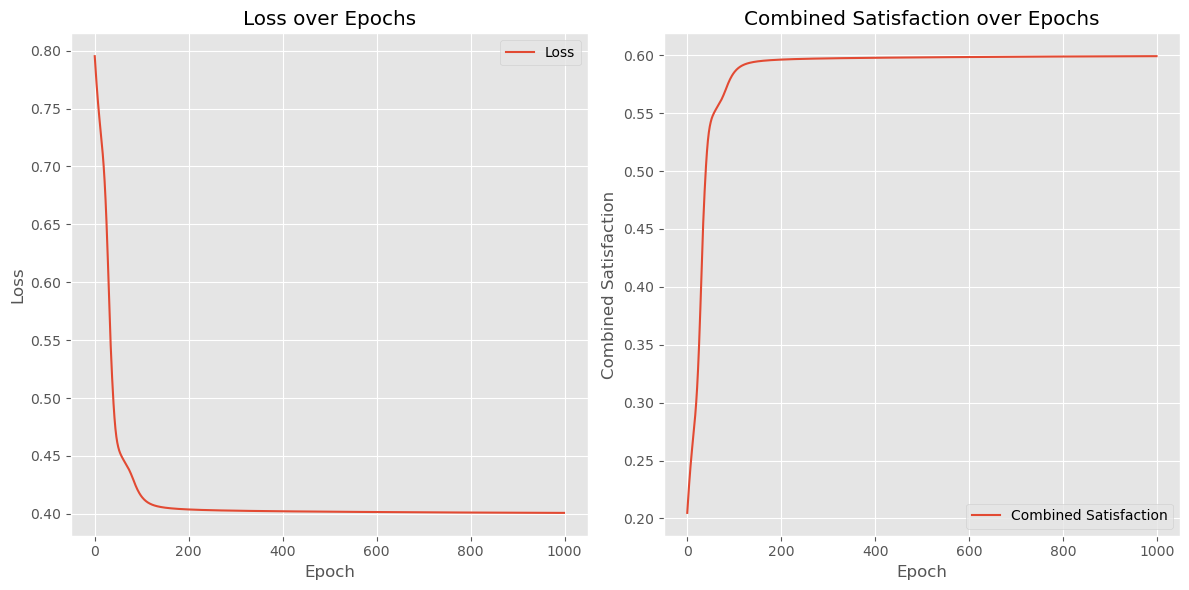

In [36]:
plt.style.use('ggplot')
# Convert the data into tensors
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32).unsqueeze(-1)
power_tensor = torch.tensor(data['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32).unsqueeze(-1)
demand_limit_tensor = torch.tensor(data['DEMAND_LIMIT'].values, dtype=torch.float32).unsqueeze(-1)
# Convert tensors to LTN Variables
SOC = ltn.Variable('soc', soc_tensor)
GARAGE_EXTERNAL_POWER = ltn.Variable('garage_power', power_tensor)
DEMAND_LIMIT = ltn.Variable('demand_limit', demand_limit_tensor)
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 4),# output 4 values for 4 rules
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)
model = BatteryManagementModel()
# Define the conditions function
def conditions(soc, garage_power):
    inputs = torch.cat([soc.value, garage_power.value], dim=1)
    return model(inputs)
# Define the LTN predicates using functions
def greater_than_80(x):
    return x > 80
def between_40_and_80(x):
    return (x > 40) & (x <= 80)
def less_than_40(x):
    return x <= 40
def less_than_15(x):
    return x < 15
def greater_than_demand_limit(garage_power, demand_limit):
    return garage_power > demand_limit
# Instantiate predicates
SOC_gt_80 = ltn.Predicate(func=greater_than_80)
SOC_between_40_and_80 = ltn.Predicate(func=between_40_and_80)
SOC_lt_40 = ltn.Predicate(func=less_than_40)
SOC_lt_15 = ltn.Predicate(func=less_than_15)
GARAGE_POWER_gt_DEMAND_LIMIT = ltn.Predicate(func=greater_than_demand_limit)
# Define the logical rules as functions
def rule1():
    condition = SOC_gt_80(SOC).value
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER)[:, 0]
def rule2():
    condition = torch.logical_and(SOC_between_40_and_80(SOC).value, 
                                  GARAGE_POWER_gt_DEMAND_LIMIT(GARAGE_EXTERNAL_POWER, DEMAND_LIMIT).value)
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER)[:, 1]
def rule3():
    condition = torch.logical_and(SOC_lt_40(SOC).value, 
                                  GARAGE_POWER_gt_DEMAND_LIMIT(GARAGE_EXTERNAL_POWER, DEMAND_LIMIT).value)
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER)[:, 2]
def rule4():
    condition = SOC_lt_15(SOC).value
    return condition * conditions(SOC, GARAGE_EXTERNAL_POWER)[:, 3]
# Define custom logical OR operation for combining axioms
def logical_or(*args):
    return 1 - torch.prod(1 - torch.stack(args))
def evaluate_rule(rule):
    return torch.mean(rule)
# Axioms combining the rules
def axioms():
    sat_rule1 = evaluate_rule(rule1())
    sat_rule2 = evaluate_rule(rule2())
    sat_rule3 = evaluate_rule(rule3())
    sat_rule4 = evaluate_rule(rule4())
    return logical_or(sat_rule1, sat_rule2, sat_rule3, sat_rule4), sat_rule1, sat_rule2, sat_rule3, sat_rule4
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
satisfactions1 = []
for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction1, sat_rule1, sat_rule2, sat_rule3, sat_rule4 = axioms()
    loss = 1 - satisfaction1
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    satisfactions1.append(satisfaction1.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Combined Satisfaction {satisfaction1.item()}")
print(f"Final Loss: {loss.item()}, Final Combined Satisfaction: {satisfaction1.item()}")
# Plot the loss and combined satisfaction for each epoch
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(satisfactions1, label='Combined Satisfaction')
plt.xlabel('Epoch')
plt.ylabel('Combined Satisfaction')
plt.title('Combined Satisfaction over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

- 2. Rules from NN based on BATTERY_SOC:

SOC < 15%:

Battery Discharge Stopped due to Battery Health: This region suggests that when the SOC is below 18%, discharging of the battery is stopped to preserve the health of the battery. This is likely a protective measure to avoid deep discharge cycles that can significantly reduce battery lifespan.

15 % ≤ SOC ≤ 47.5%:

Battery Charged from Grid: In this SOC range, the battery is primarily charged from the grid. This could imply that the battery charges when there is excess power available from the grid or when it is economically feasible to do so. This range suggests a stable operation where the battery maintains a healthy charge level without risking deep discharge.


SOC > 47.5%:

Partially Covered by Local Battery: When the SOC is above 80%, the local battery partially covers the power demands. This might indicate that the battery has enough charge to support some operations independently, but not fully, perhaps to maintain a reserve of charge for peak demands or emergencies

Epoch 0: Loss 0.6270520091056824, Combined Satisfaction 0.3729479908943176
Epoch 1: Loss 0.6197963356971741, Combined Satisfaction 0.3802036643028259
Epoch 2: Loss 0.6116170287132263, Combined Satisfaction 0.3883829712867737
Epoch 3: Loss 0.6017457246780396, Combined Satisfaction 0.39825427532196045
Epoch 4: Loss 0.5893673300743103, Combined Satisfaction 0.4106326699256897
Epoch 5: Loss 0.5737155675888062, Combined Satisfaction 0.42628443241119385
Epoch 6: Loss 0.5540779232978821, Combined Satisfaction 0.4459220767021179
Epoch 7: Loss 0.5299980044364929, Combined Satisfaction 0.4700019955635071
Epoch 8: Loss 0.5016074776649475, Combined Satisfaction 0.4983925223350525
Epoch 9: Loss 0.46998101472854614, Combined Satisfaction 0.5300189852714539
Epoch 10: Loss 0.43721508979797363, Combined Satisfaction 0.5627849102020264
Epoch 11: Loss 0.4059562087059021, Combined Satisfaction 0.5940437912940979
Epoch 12: Loss 0.37851130962371826, Combined Satisfaction 0.6214886903762817
Epoch 13: Loss 0.

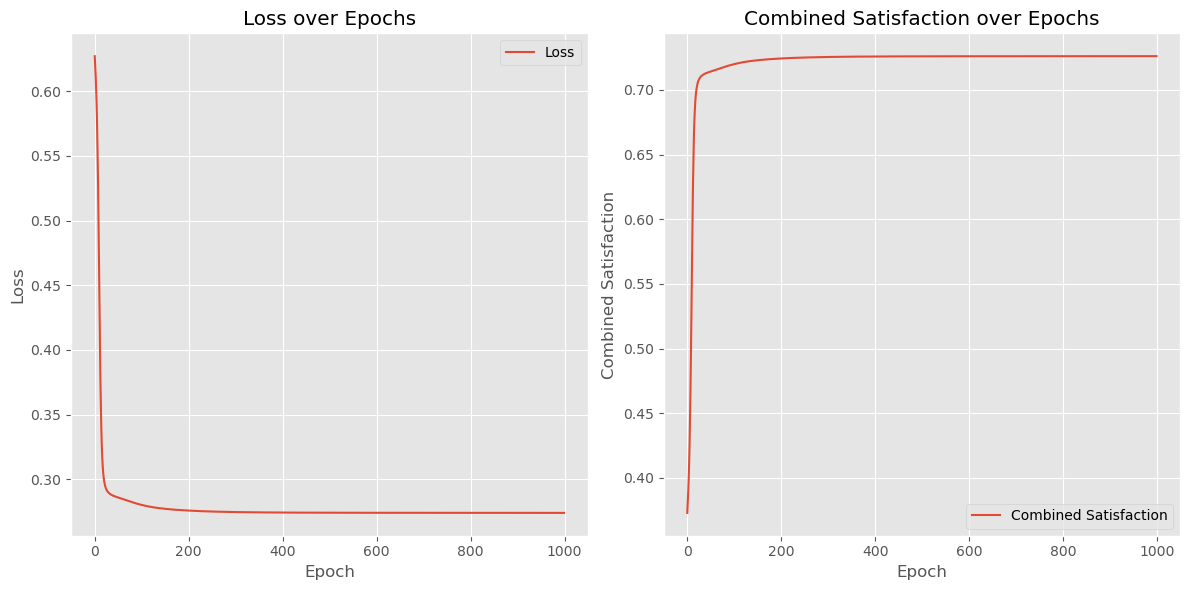

In [37]:
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32).unsqueeze(-1)
# Convert tensors to LTN Variables
SOC = ltn.Variable('soc', soc_tensor)
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 3),  #  3 values for 3 rules
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)
model = BatteryManagementModel()
# Define the conditions function
def conditions(soc):
    inputs = soc.value
    return model(inputs)
# Define the LTN predicates using functions
def less_than_15(x):
    return x < 17
def between_15_and_47(x):
    return (x >= 17) & (x <= 47.5)
def greater_than_47(x):
    return x > 47.5
# Instantiate predicates
SOC_lt_15 = ltn.Predicate(func=less_than_15)
SOC_between_15_and_47 = ltn.Predicate(func=between_15_and_47)
SOC_gt_47 = ltn.Predicate(func=greater_than_47)
# Define the logical rules as functions
def rule1():
    condition = SOC_lt_15(SOC).value
    return condition * conditions(SOC)[:, 0]
def rule2():
    condition = SOC_between_15_and_47(SOC).value
    return condition * conditions(SOC)[:, 1]
def rule3():
    condition = SOC_gt_47(SOC).value
    return condition * conditions(SOC)[:, 2]
# Define custom logical OR operation for combining axioms
def logical_or(*args):
    return 1 - torch.prod(1 - torch.stack(args))
def evaluate_rule(rule):
    return torch.mean(rule)
# Axioms combining the rules
def axioms():
    sat_rule1 = evaluate_rule(rule1())
    sat_rule2 = evaluate_rule(rule2())
    sat_rule3 = evaluate_rule(rule3())
    return logical_or(sat_rule1, sat_rule2, sat_rule3), sat_rule1, sat_rule2, sat_rule3
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
satisfactions2 = []

for epoch in range(1000):
    optimizer.zero_grad()
    satisfaction2, sat_rule1, sat_rule2, sat_rule3 = axioms()
    loss = 1 - satisfaction2
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    satisfactions2.append(satisfaction2.item())
    if epoch % 1 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Combined Satisfaction {satisfaction2.item()}")
print(f"Final Loss: {loss.item()}, Final Combined Satisfaction: {satisfaction2.item()}")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(satisfactions2, label='Combined Satisfaction')
plt.xlabel('Epoch')
plt.ylabel('Combined Satisfaction')
plt.title('Combined Satisfaction over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

- 3. Checking rules for 'BATTERY_SOC' and 'WALLBOX_FASTCHARGER_POWER' parameter combinations. 2 parameters model

In [38]:
y = df_GT['DRAWN_FROM']
X = df_GT[['BATTERY_SOC', "WALLBOX_FASTCHARGER_POWER"]]
mlp_simple = MLPClassifier(hidden_layer_sizes=(100,52, 52), random_state=42)
mlp_simple.fit(X, y)
prediction = mlp_simple.predict(g_df[["BATTERY_SOC", "WALLBOX_FASTCHARGER_POWER"]])

In [39]:
# Create a grid of 'BATTERY_SOC' and 'WALLBOX_FASTCHARGER_POWER' parameter combinations
battery_soc = np.arange(0, 101, 1)
wallbox_power = np.arange(0, 201, 1)
battery_soc_grid, wallbox_power_grid = np.meshgrid(battery_soc, wallbox_power)
grid_df = pd.DataFrame({
    'BATTERY_SOC': battery_soc_grid.ravel(),
    'WALLBOX_FASTCHARGER_POWER': wallbox_power_grid.ravel()
})
# Use the 'mlp_simple' model to predict the class for each combination
predictions = mlp_simple.predict(grid_df)
le = LabelEncoder()
numerical_predictions = le.fit_transform(predictions)
numerical_predictions = numerical_predictions.reshape(battery_soc_grid.shape)

In [40]:
predictions

array(['Battery Discharge Stopped due to Battery Health',
       'Battery Discharge Stopped due to Battery Health',
       'Battery Discharge Stopped due to Battery Health', ...,
       'Partially Covered by Local Battery',
       'Partially Covered by Local Battery',
       'Partially Covered by Local Battery'], dtype='<U47')

In [41]:
grid_df['PREDICTIONS'] = predictions
data = grid_df

Epoch 0: Loss 0.5601373314857483, Combined Satisfaction 0.4398626685142517
Epoch 100: Loss 0.24047636985778809, Combined Satisfaction 0.7595236301422119
Epoch 200: Loss 0.23897784948349, Combined Satisfaction 0.76102215051651
Epoch 300: Loss 0.2384582757949829, Combined Satisfaction 0.7615417242050171
Epoch 400: Loss 0.23816007375717163, Combined Satisfaction 0.7618399262428284
Final Loss: 0.2380465865135193, Final Combined Satisfaction: 0.7619534134864807


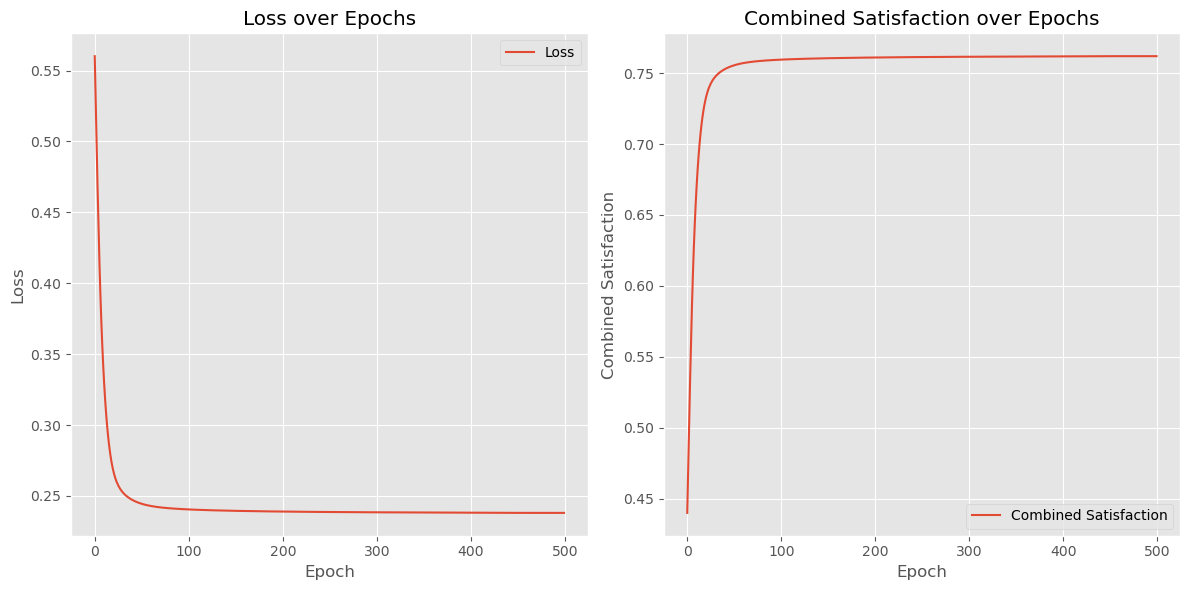

In [42]:
# Prepare the tensors for the LTN variables
soc_tensor = torch.tensor(data['BATTERY_SOC'].values, dtype=torch.float32).unsqueeze(-1)
power_tensor = torch.tensor(data['WALLBOX_FASTCHARGER_POWER'].values, dtype=torch.float32).unsqueeze(-1)
# Convert tensors to LTN Variables
SOC = ltn.Variable('soc', soc_tensor)
POWER = ltn.Variable('power', power_tensor)
# BatteryManagementModel
class BatteryManagementModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 3),  # 3 values for 3 rules
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.layers(x)

model = BatteryManagementModel()

# conditions function
def conditions(soc, power):
    inputs = torch.cat((soc.value, power.value), dim=1)
    return model(inputs)
# LTN predicates using functions
def soc_lt_15(x):
    return x < 14

def soc_ge_15(x):
    return x >= 14

def power_lt_50(x):
    return x <= 60

def power_le_70(x):
    return x <= 70

def power_gt_60(x):
    return x > 50
# Instantiate predicates
SOC_lt_15 = ltn.Predicate(func=soc_lt_15)
SOC_ge_15 = ltn.Predicate(func=soc_ge_15)
POWER_lt_50 = ltn.Predicate(func=power_lt_50)
POWER_le_70 = ltn.Predicate(func=power_le_70)
POWER_gt_60 = ltn.Predicate(func=power_gt_60)
# Define the logical rules as functions
def rule1():
    condition = torch.logical_and(SOC_lt_15(SOC).value, POWER_lt_50(POWER).value)
    return condition * conditions(SOC, POWER)[:, 0]

def rule2():
    condition = torch.logical_and(SOC_ge_15(SOC).value, POWER_le_70(POWER).value)
    return condition * conditions(SOC, POWER)[:, 1]

def rule3():
    condition = torch.logical_and(SOC_ge_15(SOC).value, POWER_gt_60(POWER).value)
    return condition * conditions(SOC, POWER)[:, 2]
# Define custom logical OR operation for combining axioms
def logical_or(*args):
    return 1 - torch.prod(1 - torch.stack(args))
def evaluate_rule(rule):
    return torch.mean(rule)

def axioms():
    sat_rule1 = evaluate_rule(rule1())
    sat_rule2 = evaluate_rule(rule2())
    sat_rule3 = evaluate_rule(rule3())
    return logical_or(sat_rule1, sat_rule2, sat_rule3), sat_rule1, sat_rule2, sat_rule3

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
losses = []
satisfactions3 = []

for epoch in range(500):
    optimizer.zero_grad()
    satisfaction3, sat_rule1, sat_rule2, sat_rule3 = axioms()
    loss = 1 - satisfaction3
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    satisfactions3.append(satisfaction3.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}, Combined Satisfaction {satisfaction3.item()}")

print(f"Final Loss: {loss.item()}, Final Combined Satisfaction: {satisfaction3.item()}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(satisfactions3, label='Combined Satisfaction')
plt.xlabel('Epoch')
plt.ylabel('Combined Satisfaction')
plt.title('Combined Satisfaction over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

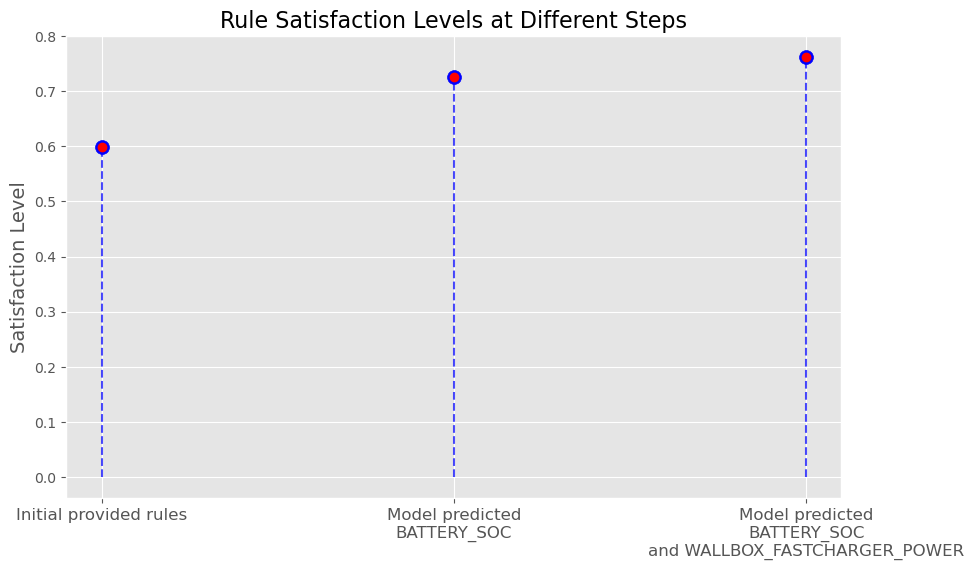

In [50]:
x_labels = ['Initial provided rules', 
            'Model predicted\nBATTERY_SOC', 
            'Model predicted\nBATTERY_SOC\nand WALLBOX_FASTCHARGER_POWER']
y_values = [ satisfaction1.item(),  satisfaction2.item(),  satisfaction3.item()]
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.scatter(x_labels, y_values, color='blue', s=100)  # Increased size of points
for i, y in enumerate(y_values):
    plt.vlines(i, ymin=0, ymax=y, color='blue', linestyle='--', alpha=0.7)
plt.plot(x_labels, y_values, 'ro')
plt.title('Rule Satisfaction Levels at Different Steps', fontsize=16)
plt.ylabel('Satisfaction Level', fontsize=14)
plt.xticks(fontsize=12)
plt.grid(True)
# Display the plot
plt.show()
